# Transfer Learning Tutorial with Early Stopping
This tutorial demonstrates how to train a convolutional neural network for image classification using transfer learning.

It is based on [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), but it uses **45 Pretrained models for Pytorch** from [this repository](https://github.com/Cadene/pretrained-models.pytorch) instead of the basic [12 torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

It also implements early stopping, original source code [here](https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d).

To run this tutorial:
1. Add [pretrained-models.pytorch](https://www.kaggle.com/rishabhiitbhu/pretrainedmodels) dataset
2. Add [Pretrained Model Weights (Pytorch)](https://www.kaggle.com/abhishek/pretrained-model-weights-pytorch) dataset
3. Add [PyTorch Transfer Learning Tutorial: Bees and Ants](https://www.kaggle.com/carlossouza/pytorchtransferlearningtutorial) dataset

# 1. Install Pretrainedmodels package and import packages
All packages are available without internet, except [pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch). After adding the datasets, run the cell below to install it.

In [1]:
%%time
!pip install '/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4'

Processing /kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=495d8e4d142867e6c38f4aad5fe4dd1b104f350cb5a4e16f13a637b962b1b272
  Stored in directory: /tmp/.cache/pip/wheels/52/1a/2a/9e4582032d4e47d36ff06371d5579b3a6622985bdf37ee4b20
Successfully built pretrainedmodels
CPU times: user 428 ms, sys: 180 ms, total: 608 ms
Wall time: 29.8 s


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pretrainedmodels
import pretrainedmodels.utils as utils
from shutil import copyfile
os.environ['TORCH_HOME'] = '/kaggle/working/pretrained-model-weights-pytorch'

# 2. Load the model
All available pre-trained models can be seen in the cell below. Pick one to do it. We've chosen **xception** to run this tutorial.

It is important to copy the pre-trained model weights to a directory. That's what **copy_weights** do.

In [3]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [4]:
def copy_weights(model_name):
    found = False
    for dirname, _, filenames in os.walk('/kaggle/input/pretrained-model-weights-pytorch'):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            if filename.startswith(model_name):
                found = True
                break
        if found:
            break
            
    base_dir = "/kaggle/working/pretrained-model-weights-pytorch/checkpoints"
    os.makedirs(base_dir, exist_ok=True)
    filename = os.path.basename(full_path)
    copyfile(full_path, os.path.join(base_dir, filename))

In [5]:
copy_weights('xception')
model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model.eval()
tf_img = utils.TransformImage(model)

# 2. Load data
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet. It's the same data used in PyTorch official documentation.

In [6]:
data_dir = '/kaggle/input/pytorchtransferlearningtutorial/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          tf_img)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

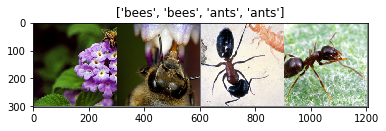

In [7]:
def imshow(inp, model=model, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = model.std * inp + model.mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 4. Train the model
This is a general function to train a model, exactly as in PyTorch official documentation.

## 4.1. Early Stopping

In [8]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            print('improvement!')
        else:
            self.num_bad_epochs += 1
            print(f'no improvement, bad_epochs counter: {self.num_bad_epochs}')

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    
    es = EarlyStopping(patience=patience)
    terminate_training = False
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and es.step(epoch_loss):
                terminate_training = True
                print('early stop criterion is met, we can stop now')
                break
    
        print()
        if terminate_training:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 5. Visualizing the model predictions
Generic function to display predictions for a few images.

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 6. Finetuning the convnet
Here we reset final fully connected layer.

In [11]:
model_ft = model
num_ftrs = model_ft.last_linear.in_features
model_ft.last_linear = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 7. Train and evaluate
Here we train the model. It takes less than 2min using a GPU.

In [12]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5318 Acc: 0.7295
val Loss: 0.2794 Acc: 0.9542

Epoch 1/99
----------
train Loss: 0.2746 Acc: 0.9221
val Loss: 0.1531 Acc: 0.9935
improvement!

Epoch 2/99
----------
train Loss: 0.2540 Acc: 0.8975
val Loss: 0.1254 Acc: 0.9869
improvement!

Epoch 3/99
----------
train Loss: 0.2595 Acc: 0.8934
val Loss: 0.1167 Acc: 0.9869
improvement!

Epoch 4/99
----------
train Loss: 0.1773 Acc: 0.9303
val Loss: 0.1003 Acc: 0.9869
improvement!

Epoch 5/99
----------
train Loss: 0.2064 Acc: 0.9057
val Loss: 0.0895 Acc: 0.9869
improvement!

Epoch 6/99
----------
train Loss: 0.1108 Acc: 0.9590
val Loss: 0.0891 Acc: 0.9935
improvement!

Epoch 7/99
----------
train Loss: 0.1542 Acc: 0.9508
val Loss: 0.0798 Acc: 0.9869
improvement!

Epoch 8/99
----------
train Loss: 0.1422 Acc: 0.9344
val Loss: 0.0918 Acc: 0.9869
no improvement, bad_epochs counter: 1

Epoch 9/99
----------
train Loss: 0.1053 Acc: 0.9754
val Loss: 0.0840 Acc: 0.9869
no improvement, bad_epochs counter: 2

Epo

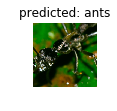

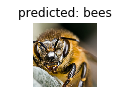

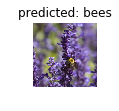

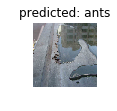

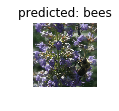

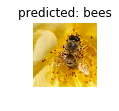

In [13]:
visualize_model(model_ft)